# Qiskit config

In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.test.mock import FakeMontreal, FakeMumbai

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'

from qiskit_ionq import IonQProvider
provider_ionq = IonQProvider()

In [2]:
backend_0  = Aer.get_backend('qasm_simulator') 
backend_1  = provider.get_backend('ibmq_qasm_simulator')
backend_2  = provider.get_backend('ibmq_santiago')
backend_3  = provider.get_backend('ibmq_manila')
backend_4  = provider.get_backend('ibmq_casablanca')
backend_5  = provider.get_backend('ibmq_jakarta')
backend_6  = provider.get_backend('ibm_lagos')

backend_7  = FakeMontreal()
backend_8  = FakeMumbai()

backend_9 = provider_ionq.get_backend("ionq_simulator")
backend_10 = provider_ionq.get_backend("ionq_qpu")

shots      = 8192

"""
    Select the backends that will be compared.
"""

backends = [ backend_0 ]


# Experiment procedures

In [3]:
import numpy as np
import sys
import warnings
sys.path.append('../../')
from qclib.state_preparation.schmidt import initialize

warnings.filterwarnings("ignore")

def svd(state_vector):
    state = np.copy(state_vector)

    n_qubits = int(np.log2(len(state)))
    odd = n_qubits % 2
    lines = int(2**(n_qubits//2))
    cols = int(2**(n_qubits//2 + odd))
    state.shape = (lines, cols)

    svd_u, singular_values, svd_v = np.linalg.svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)

    return svd_u, singular_values, svd_v

def purity(singular_values):
    return np.sum(np.power(singular_values, 4))

def measurement(circuit, c):
    n = len(c)
    circuit.measure(list(range(n)), c)

    job = execute(circuit, backend, shots=shots) # , optimization_level=3)
    
    counts = job.result().get_counts(circuit)
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**n):
        pattern = '{:0{}b}'.format(m, n)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0
            
    return { key : value/v for (key, value) in counts2.items() }
    
def run_circuit(state, r=0):
    circuit = initialize(state, r)

    n = int(np.log2(len(input_state)))
    c = ClassicalRegister(n)
    circuit.barrier()
    circuit.add_register(c)

    prob = measurement(circuit, c)
    
    return np.array([val for key, val in prob.items()])

# Experiment

In [4]:
reps = 10
min_n = 3
max_n = 10

In [7]:
states = {}

# Random complex input vector.
rnd = np.random.RandomState(42)
for n in range(min_n, max_n+1):
    state = rnd.rand(2**n) + rnd.rand(2**n) * 1j
    states[2**n] = state/np.linalg.norm(state)

# Fixed real 8- and 16-dim input vector.
#states[8] = [np.sqrt(0.03), np.sqrt(0.06), np.sqrt(0.15), np.sqrt(0.05), np.sqrt(0.1), np.sqrt(0.3), np.sqrt(0.2), np.sqrt(0.11) ]
#states[16] = input_state = [np.sqrt(0.01), np.sqrt(0.02), np.sqrt(0.04), np.sqrt(0.02), np.sqrt(0.07), np.sqrt(0.08), np.sqrt(0.04), np.sqrt(0.01), np.sqrt(0.08), np.sqrt(0.02), np.sqrt(0.21), np.sqrt(0.09), np.sqrt(0.12), np.sqrt(0.08), np.sqrt(0.05), np.sqrt(0.06) ]

for r, state in states.items():
    u, sv, v = svd(state/np.linalg.norm(state))
    p = purity(sv)
    print('n = {0}\tpurity = {1}\n'.format(int(np.log2(r)), p))
    #print('\tsingular values:', sv)


n = 3	purity = 0.7644663507593948

n = 4	purity = 0.738044488018214

n = 5	purity = 0.7079597577862856

n = 6	purity = 0.6653383698411146

n = 7	purity = 0.6588382835655807

n = 8	purity = 0.6221890501242325

n = 9	purity = 0.5957708949339906

n = 10	purity = 0.5860499680216101



In [8]:
ideals = {}
result = {}
for n in range(min_n, max_n+1):
    print('n =', n)
    
    input_state = states[2**n]
    
    ideals[n] = np.power(np.abs(input_state), 2)

    result[n] = {}
    for j, backend in enumerate(backends):
        backend_name = backend.name()
        backend_config = backend.configuration()
        backend_qubits = backend_config.n_qubits

        print('\nExperiments using {0} backend, with {1} qubits available.'.format(backend_name, backend_qubits))

        result[n][backend_name] = {}

        for r in [2**m for m in range(n//2+1)][::-1]: # iso:{1<=rank<2**(n_qubits//2)};uni:{rank=2**(n_qubits//2)}
            print('\trank =', r, ' run: ', end='')

            probs = []
            for i in range(reps):
                print(i, ' ', end='')
                probs.append( run_circuit(input_state, r) )
            print('')
            result[n][backend_name][r] = probs



n = 3

Experiments using qasm_simulator backend, with 29 qubits available.
	rank = 2  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 1  run: 0  1  2  3  4  5  6  7  8  9  
n = 4

Experiments using qasm_simulator backend, with 29 qubits available.
	rank = 4  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 2  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 1  run: 0  1  2  3  4  5  6  7  8  9  
n = 5

Experiments using qasm_simulator backend, with 29 qubits available.
	rank = 4  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 2  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 1  run: 0  1  2  3  4  5  6  7  8  9  
n = 6

Experiments using qasm_simulator backend, with 29 qubits available.
	rank = 8  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 4  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 2  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 1  run: 0  1  2  3  4  5  6  7  8  9  
n = 7

Experiments using qasm_simulator backend, with 29 qubits available.
	rank = 8  run: 0  1  2  3  4  5  6  7  8  9  
	rank = 4  run

# Print Results

In [9]:
def print_result(ideal, probs):
    n = int(np.log2(len(ideal)))
    averages = { key: np.mean(prob, axis=0) for key, prob in probs.items() }

    for r, prob in averages.items():
        mae = np.sum( np.abs( prob - ideal ) ) / 2**n
        print('\trank =', r, 'MAE =', mae)
        #print('\tIdeal probabilities:')
        #print('\t', ideal)
        #print('\tAverage probabilities:')
        #print('\t', prob)
    
for n in range(min_n, max_n+1):
    print('n =', n)
    for j, backend in enumerate(backends):
        print('\nbackend =', backend.name())
        print_result(ideals[n], result[n][backend.name()])


n = 3

backend = qasm_simulator
	rank = 2 MAE = 0.0005372115250025373
	rank = 1 MAE = 0.051241791780473445
n = 4

backend = qasm_simulator
	rank = 4 MAE = 0.0006203690653635234
	rank = 2 MAE = 0.019433262055066673
	rank = 1 MAE = 0.02869460263066819
n = 5

backend = qasm_simulator
	rank = 4 MAE = 0.0003394583274911534
	rank = 2 MAE = 0.009835042452395951
	rank = 1 MAE = 0.015005058924409
n = 6

backend = qasm_simulator
	rank = 8 MAE = 0.000328195120779566
	rank = 4 MAE = 0.002916667867244704
	rank = 2 MAE = 0.00587995142019662
	rank = 1 MAE = 0.007680296336936212
n = 7

backend = qasm_simulator
	rank = 8 MAE = 0.00019616168815327442
	rank = 4 MAE = 0.0017617538355537668
	rank = 2 MAE = 0.0028300497065775693
	rank = 1 MAE = 0.00323670746184192
n = 8

backend = qasm_simulator
	rank = 16 MAE = 0.00015944033010504015
	rank = 8 MAE = 0.0008092586954783908
	rank = 4 MAE = 0.0013656487058229148
	rank = 2 MAE = 0.0016949749495774502
	rank = 1 MAE = 0.0019251912063466576
n = 9

backend = qasm_s

# Plot Charts

n = 3
backend = qasm_simulator


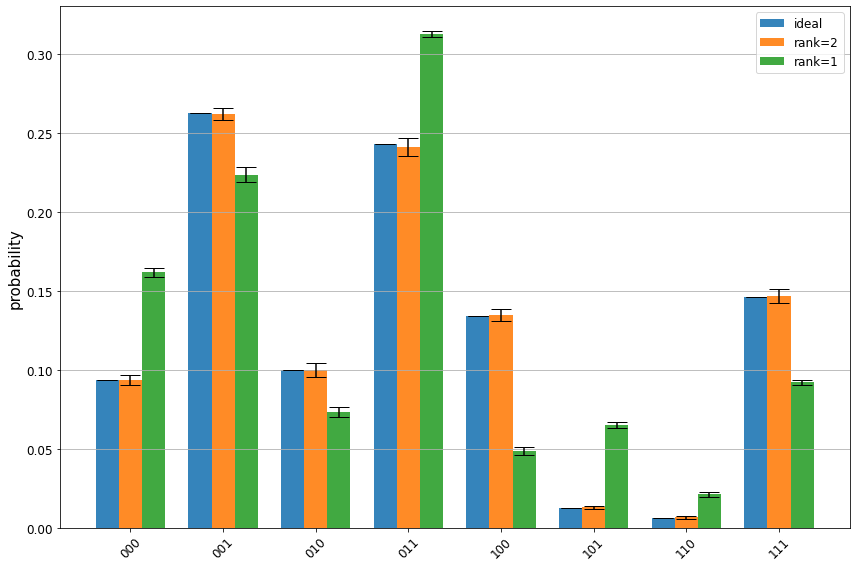

n = 4
backend = qasm_simulator


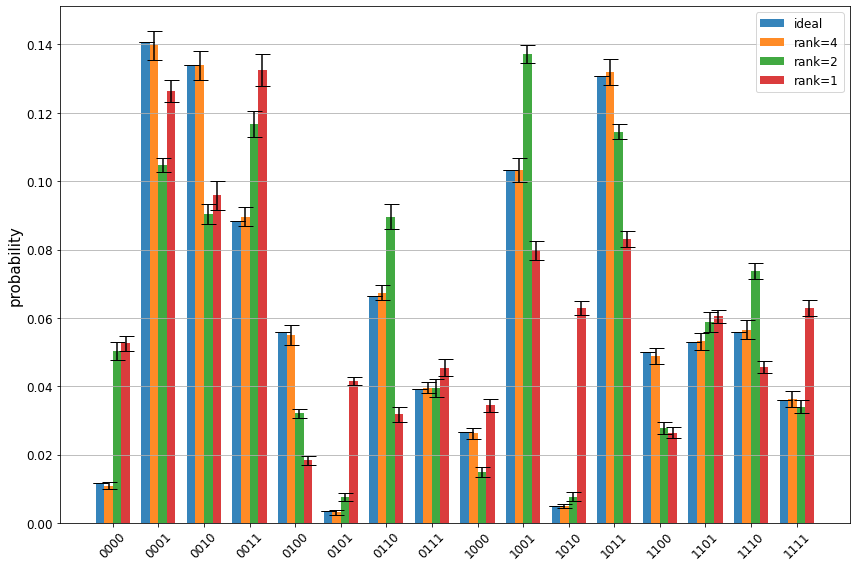

n = 5
backend = qasm_simulator


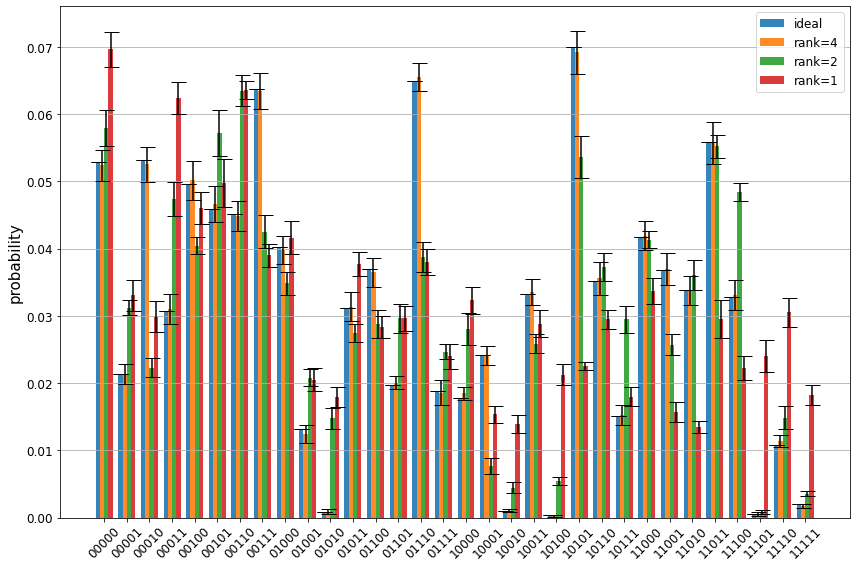

n = 6
backend = qasm_simulator


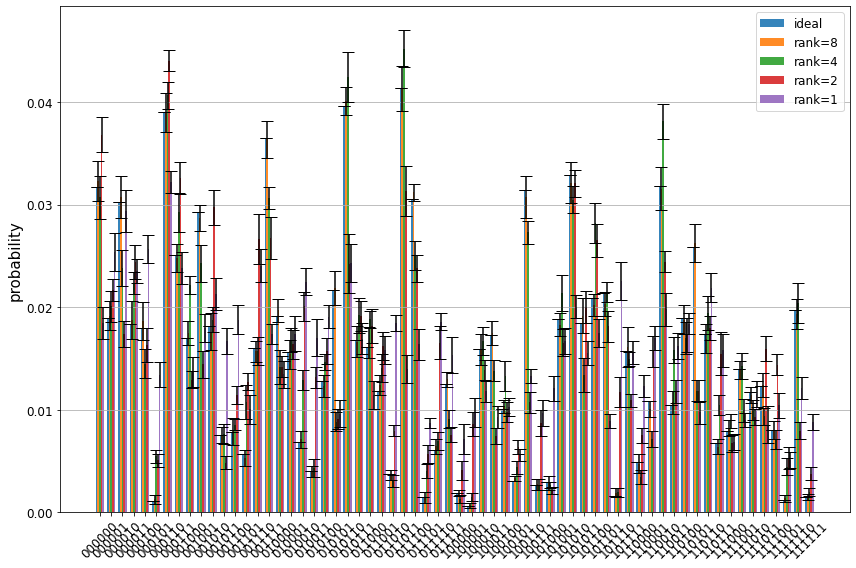

n = 7
backend = qasm_simulator


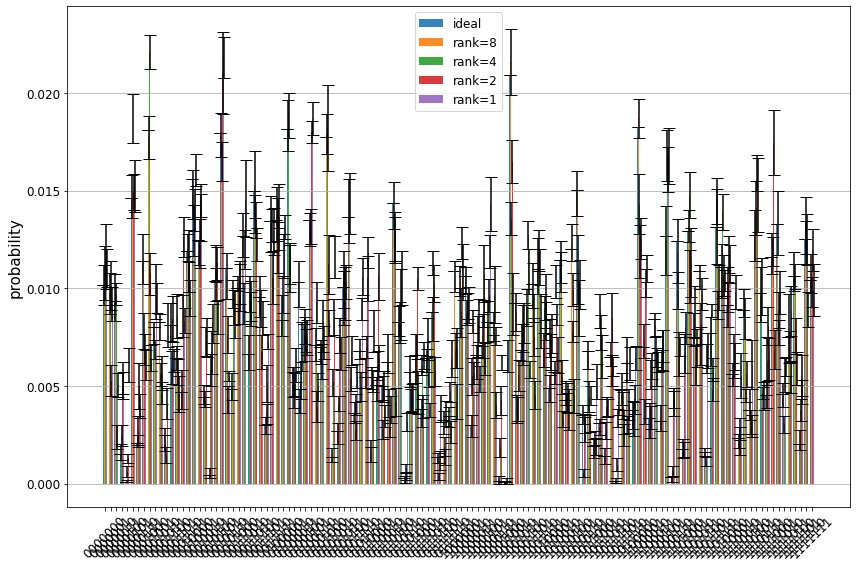

n = 8
backend = qasm_simulator


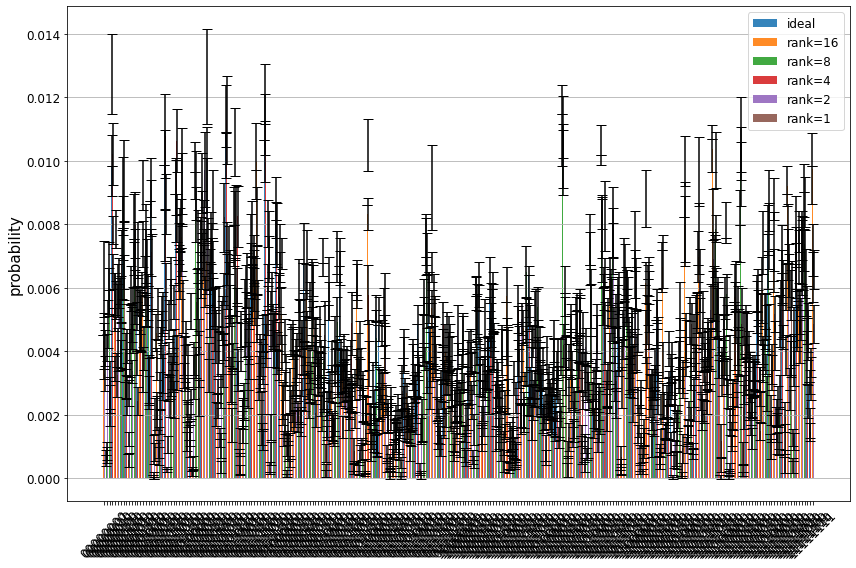

n = 9
backend = qasm_simulator


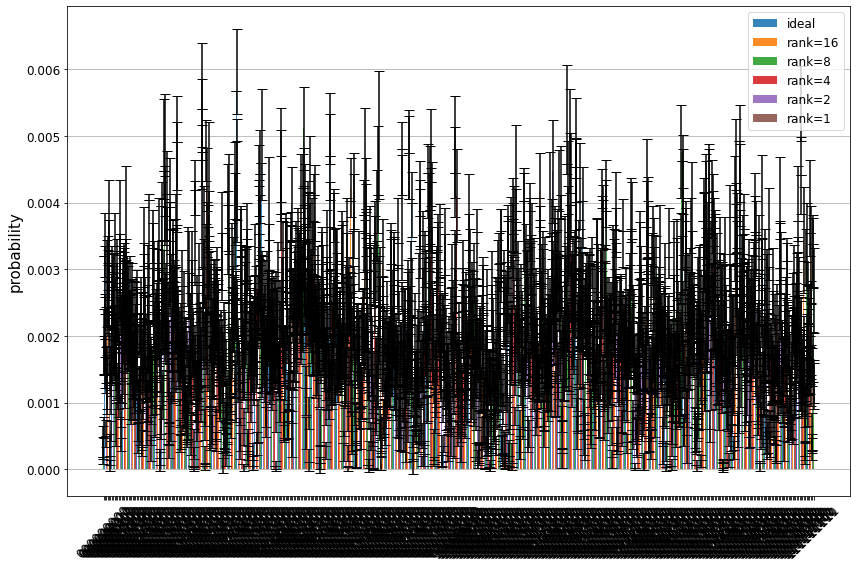

n = 10
backend = qasm_simulator


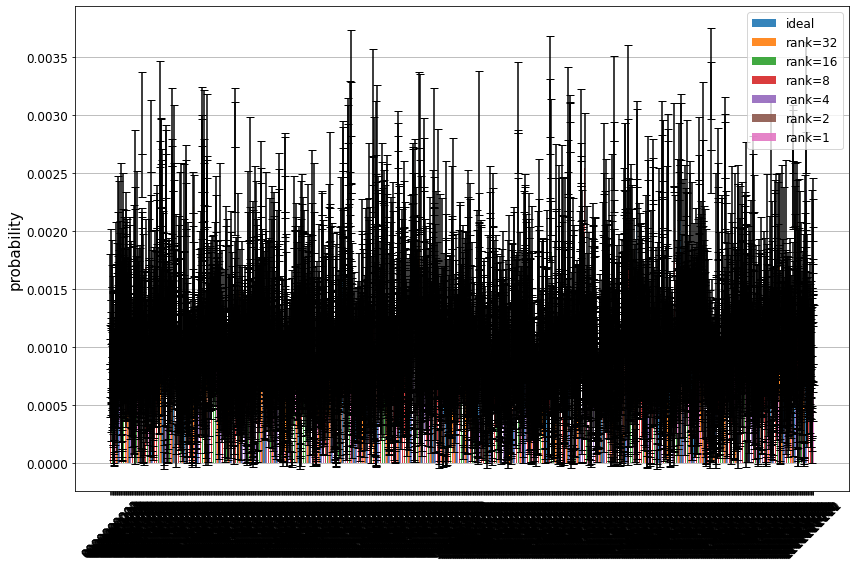

In [10]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot(labels, averages, stds, xticks):
    n_bars = len(xticks)
    n_labels = len(labels)
    
    b_width = (1/n_labels)*0.75
    fig = plt.subplots(figsize = (12, 8))

    x_pos = np.arange(n_bars)
    for i, avg in enumerate(averages):
        plt.bar(x_pos, avg, yerr = stds[i], width = b_width, label = labels[i],
                align='center', alpha=0.9, ecolor='black', capsize=b_width*40)
        
        x_pos = [x + b_width for x in x_pos]
    
    plt.ylabel('probability', fontsize = 15)
    plt.xticks([x + b_width*(n_labels-1)/2 for x in range(n_bars)], xticks, fontsize=12, rotation=45)
    plt.grid(b=True, axis='y')
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

def plot_result(ideal, probs):
    n = int(np.log2(len(ideal)))
    labels   = [ "rank="+str(key) for key, val in probs.items() ]
    averages = [ np.mean(prob, axis=0) for key, prob in probs.items() ]
    stds     = [ np.std(prob , axis=0) for key, prob in probs.items() ]
    xticks   = ['{:0{}b}'.format(p, n) for p in range(2**n)]

    labels.insert(0, 'ideal')
    averages.insert(0, ideal)
    stds.insert(0, [0]*len(ideal))

    plot(labels, averages, stds, xticks)
    
for n in range(min_n, max_n+1):
    print('n =', n)
    for j, backend in enumerate(backends):
        print('backend =', backend.name())
        plot_result(ideals[n], result[n][backend.name()])